
# 🧪 Model Drift Lab (Classification) — Step-by-Step (TH/EN)

**เป้าหมายการเรียนรู้ (Learning Goals):**
1) สร้าง **custom pandas dataset** ที่มีทั้งคอลัมน์เชิงตัวเลขและเชิงหมวดหมู่ (numeric + categorical).  
2) ฝึก **Baseline Model (v1)** และจำลอง **Model Drift (v2)** โดยที่ distribution ของ input แทบไม่เปลี่ยน — โฟกัสที่ model เสื่อมเอง.  
3) ตรวจสอบ Model Drift ด้วยหลายมุมมอง:  
   - Metric drop (Accuracy, F1, ROC-AUC, Log Loss)  
   - Score distribution shift: **PSI** และ **Jensen–Shannon Divergence (JSD)** บน **predicted probability**  
   - Calibration / **Brier score** และ Reliability curve (เชิงคุณภาพ)  
   - **Confusion matrix** shift ระหว่างช่วงอ้างอิงกับช่วงปัจจุบัน  
4) สร้าง **Evidently** report (Classification Performance) เพื่อสรุปผลการตรวจสอบแบบสวยงาม

> หมายเหตุ: Notebook นี้ **ไม่มีการใช้ฟังก์ชันหรือคลาสที่ผู้ใช้สร้างเอง** เพื่อให้ผู้เรียนอ่านตามทีละเซลล์ได้ง่าย



## 1) Environment Setup

ถ้ายังไม่มีไลบรารี ให้รันเซลล์ถัดไปเพื่อติดตั้ง (ข้ามได้ถ้าติดตั้งแล้ว)
- `pandas`, `numpy`, `scikit-learn`
- `scipy` (สำหรับ JSD)
- `matplotlib` (สำหรับกราฟ)
- `evidently` (รายงาน Model Performance).

> หากใช้ Evidently เวอร์ชันใหม่ (≥ 0.4), ให้ใช้งาน preset: **`ClassificationPerformancePreset`** จาก `evidently.metric_preset`.


In [19]:

import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

# pip install --upgrade evidently==0.7.14

# Clean up the notebook
clean_notebook()
import evidently
print(evidently.__version__)


Notebook cleaned.
0.7.14


In [20]:
import evidently
print(evidently.__version__)


0.7.14


In [21]:

# !pip install -q pandas numpy scikit-learn scipy matplotlib evidently
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, brier_score_loss, confusion_matrix
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
import matplotlib.pyplot as plt
import numpy as np

# Evidently
from evidently import Report
from evidently.presets import ClassificationPreset, DataSummaryPreset


np.random.seed(42)
pd.set_option('display.max_columns', 100)



## 2) สร้าง Dataset แบบกำหนดเอง (Reference vs Current)

เราจะสร้าง **ปัญหาจำแนกทวิภาค (binary classification)** ที่มี:
- ตัวเลข: `age`, `income`, `clicks`
- หมวดหมู่: `country`, `device`, `channel`

เราจะแบ่งข้อมูลเป็น 2 ส่วนตามเวลา:
- **Reference** (อดีต / ช่วงอ้างอิง): ใช้ประเมิน baseline
- **Current** (ปัจจุบัน): ใช้ตรวจจับ model drift

> สำคัญ: เพื่อเน้น *Model Drift* เราจะทำให้ distribution ของ input ของ Current ใกล้เคียงกับ Reference มากที่สุด


In [22]:

# ขนาดข้อมูล
n_ref = 5000
n_cur = 5000

# ตัวเลข (continuous / count)
age_ref = np.random.normal(loc=35, scale=9, size=n_ref)
income_ref = np.random.lognormal(mean=10.2, sigma=0.45, size=n_ref)
clicks_ref = np.random.poisson(lam=4.5, size=n_ref)

age_cur = np.random.normal(loc=35.3, scale=9.2, size=n_cur)       # distribution ใกล้เคียง
income_cur = np.random.lognormal(mean=10.22, sigma=0.45, size=n_cur)
clicks_cur = np.random.poisson(lam=4.6, size=n_cur)

# หมวดหมู่
countries = np.array(["US", "TH", "JP", "IN"])
country_ref = np.random.choice(countries, size=n_ref, p=[0.45, 0.20, 0.20, 0.15])
country_cur = np.random.choice(countries, size=n_cur, p=[0.46, 0.19, 0.20, 0.15])

devices = np.array(["mobile", "desktop", "tablet"])
device_ref = np.random.choice(devices, size=n_ref, p=[0.56, 0.34, 0.10])
device_cur = np.random.choice(devices, size=n_cur, p=[0.55, 0.35, 0.10])

channels = np.array(["ads", "organic", "social"])
channel_ref = np.random.choice(channels, size=n_ref, p=[0.40, 0.40, 0.20])
channel_cur = np.random.choice(channels, size=n_cur, p=[0.40, 0.40, 0.20])

# ฟังก์ชันสร้าง y (ซ่อนอยู่) — ใช้ logistic แบบกำหนดเองเพื่อได้ป้ายกำกับ y
#  (ที่นี่เรา "ไม่" เขียนเป็นฟังก์ชันตามโจทย์ จึงคำนวณตรงๆ)
logit_ref = (
     0.06*(age_ref-35)
   + 0.35*np.log1p(income_ref)       # income มีอิทธิพลมาก
   + 0.10*(clicks_ref-4.5)
   + (country_ref=="US")*0.25
   + (device_ref=="mobile")*0.15
   + (channel_ref=="ads")*0.10
   - 7.5
)
p_ref = 1/(1+np.exp(-logit_ref))
y_ref = (np.random.rand(n_ref) < p_ref).astype(int)

logit_cur = (
     0.06*(age_cur-35)
   + 0.35*np.log1p(income_cur)
   + 0.10*(clicks_cur-4.5)
   + (country_cur=="US")*0.25
   + (device_cur=="mobile")*0.15
   + (channel_cur=="ads")*0.10
   - 7.5
)
p_cur = 1/(1+np.exp(-logit_cur))
y_cur = (np.random.rand(n_cur) < p_cur).astype(int)

ref = pd.DataFrame({
    "age": age_ref,
    "income": income_ref,
    "clicks": clicks_ref,
    "country": country_ref,
    "device": device_ref,
    "channel": channel_ref,
    "y": y_ref
})

cur = pd.DataFrame({
    "age": age_cur,
    "income": income_cur,
    "clicks": clicks_cur,
    "country": country_cur,
    "device": device_cur,
    "channel": channel_cur,
    "y": y_cur
})

ref.head(), ref['y'].mean(), cur['y'].mean()


(         age        income  clicks country   device  channel  y
 0  39.470427  22232.448461       2      IN   mobile   social  0
 1  33.755621  21937.738484       2      US   mobile  organic  0
 2  40.829197  11991.586673       5      JP   mobile   social  0
 3  48.707269  23189.605390       7      TH  desktop      ads  0
 4  32.892620  37412.983921       8      JP  desktop      ads  0,
 np.float64(0.0276),
 np.float64(0.029))


> ตรวจสอบสรุปเบื้องต้น


In [23]:

ref.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,5000.0,NaN,NaN,NaN,35.050417,8.968318,5.828594,29.078855,35.12119,40.994095,70.336139
income,5000.0,NaN,NaN,NaN,29707.287977,14265.610182,4605.101026,19752.546433,26692.750306,36488.672454,131672.7339
clicks,5000.0,NaN,NaN,NaN,4.513,2.127331,0.0,3.0,4.0,6.0,14.0
country,5000,4,US,2186,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device,5000,3,mobile,2834,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel,5000,3,organic,1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y,5000.0,NaN,NaN,NaN,0.0276,0.16384,0.0,0.0,0.0,0.0,1.0


In [24]:

cur.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,5000.0,NaN,NaN,NaN,35.236369,9.135951,2.899363,28.84788,35.031428,41.334827,74.84949
income,5000.0,NaN,NaN,NaN,30451.561465,14053.903305,6008.909242,20171.723847,27645.063003,37543.191688,130831.442301
clicks,5000.0,NaN,NaN,NaN,4.6318,2.139333,0.0,3.0,4.0,6.0,14.0
country,5000,4,US,2360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device,5000,3,mobile,2746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel,5000,3,organic,2035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y,5000.0,NaN,NaN,NaN,0.029,0.167823,0.0,0.0,0.0,0.0,1.0



## 3) ฝึก **Baseline Model v1** บน Reference และประเมินบน Current

- ใช้ **ColumnTransformer** รวม `StandardScaler` สำหรับตัวเลข และ `OneHotEncoder` สำหรับหมวดหมู่
- ใช้ **LogisticRegression** แบบค่าเริ่มต้น (เหมาะเป็น baseline)


In [25]:

X_ref = ref.drop(columns=['y'])
y_ref = ref['y']

X_cur = cur.drop(columns=['y'])
y_cur = cur['y']

numeric_cols = ["age", "income", "clicks"]
cat_cols = ["country", "device", "channel"]

preprocess = ColumnTransformer([
    ("num", StandardScaler(with_mean=True, with_std=True), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Baseline v1
model_v1 = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, n_jobs=None))  # keep simple
])

_ = model_v1.fit(X_ref, y_ref)

# ประเมินบน Reference (hold-out) และ Current
# เพื่อหลีกเลี่ยงการนิยามฟังก์ชัน เราจะแบ่งแบบ simple train/valid สำหรับ ref
Xr_train, Xr_val, yr_train, yr_val = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42, stratify=y_ref)
_ = model_v1.fit(Xr_train, yr_train)
prob_ref = model_v1.predict_proba(Xr_val)[:,1]
pred_ref = (prob_ref>=0.5).astype(int)

prob_cur_v1 = model_v1.predict_proba(X_cur)[:,1]
pred_cur_v1 = (prob_cur_v1>=0.5).astype(int)

acc_ref = accuracy_score(yr_val, pred_ref)
f1_ref = f1_score(yr_val, pred_ref)
auc_ref = roc_auc_score(yr_val, prob_ref)
ll_ref = log_loss(yr_val, prob_ref)
brier_ref = brier_score_loss(yr_val, prob_ref)

acc_cur_v1 = accuracy_score(y_cur, pred_cur_v1)
f1_cur_v1 = f1_score(y_cur, pred_cur_v1)
auc_cur_v1 = roc_auc_score(y_cur, prob_cur_v1)
ll_cur_v1 = log_loss(y_cur, prob_cur_v1)
brier_cur_v1 = brier_score_loss(y_cur, prob_cur_v1)

pd.DataFrame({
    "metric": ["Accuracy","F1","ROC-AUC","LogLoss","Brier"],
    "Reference(v1)": [acc_ref, f1_ref, auc_ref, ll_ref, brier_ref],
    "Current(v1)": [acc_cur_v1, f1_cur_v1, auc_cur_v1, ll_cur_v1, brier_cur_v1]
})


,metric,Reference(v1),Current(v1)
0,Accuracy,0.972667,0.971000
1,F1,0.000000,0.000000
2,ROC-AUC,0.516909,0.667177
3,LogLoss,0.129580,0.126404
4,Brier,0.026905,0.027844



## 4) จำลอง **Model Drift** → สร้างโมเดลที่เสื่อม (v2)

สมมติว่าเกิดเหตุการณ์ดังนี้:
- ทีมงานปรับพารามิเตอร์ผิดพลาด (เช่นตั้งค่า `C` เล็กเกินไปจน underfit) หรือ
- โมเดลโดน quantize/แปลงรูปแบบทำให้ **น้ำหนักสูญเสียความแม่นยำ**,  
ทำให้ performance แย่ลง **แม้ input distribution ใกล้เดิม**.

เราจะฝึก **v2** ด้วย Regularization ที่แรงกว่าเดิม เพื่อให้ **ประสิทธิภาพลดลง**.


In [26]:

# โมเดล v2: ทำให้ underfit อย่างตั้งใจ
model_v2 = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, C=0.1, n_jobs=None))  # C เล็ก = แรงขึ้น -> underfit
])

_ = model_v2.fit(Xr_train, yr_train)
prob_cur_v2 = model_v2.predict_proba(X_cur)[:,1]
pred_cur_v2 = (prob_cur_v2>=0.5).astype(int)

acc_cur_v2 = accuracy_score(y_cur, pred_cur_v2)
f1_cur_v2 = f1_score(y_cur, pred_cur_v2)
auc_cur_v2 = roc_auc_score(y_cur, prob_cur_v2)
ll_cur_v2 = log_loss(y_cur, prob_cur_v2)
brier_cur_v2 = brier_score_loss(y_cur, prob_cur_v2)

pd.DataFrame({
    "metric": ["Accuracy","F1","ROC-AUC","LogLoss","Brier"],
    "Reference(v1)": [acc_ref, f1_ref, auc_ref, ll_ref, brier_ref],
    "Current(v1)": [acc_cur_v1, f1_cur_v1, auc_cur_v1, ll_cur_v1, brier_cur_v1],
    "Current(v2) (drifted model)": [acc_cur_v2, f1_cur_v2, auc_cur_v2, ll_cur_v2, brier_cur_v2]
})


,metric,Reference(v1),Current(v1),Current(v2) (drifted model)
0,Accuracy,0.972667,0.971000,0.971000
1,F1,0.000000,0.000000,0.000000
2,ROC-AUC,0.516909,0.667177,0.666532
3,LogLoss,0.129580,0.126404,0.126363
4,Brier,0.026905,0.027844,0.027839



## 5) ตรวจสอบการเปลี่ยนแปลงของ **Score Distribution** (PSI & JSD)

- **PSI (Population Stability Index)**: วัดการเปลี่ยนของการกระจายสกอร์ (เช่น predicted probability) ระหว่าง **Reference** และ **Current**.  
  - แนวทางทั่วไป: PSI < 0.1 (ไม่มีปัญหา), 0.1–0.25 (เฝ้าระวัง), > 0.25 (มี Drift)  
- **Jensen–Shannon Divergence (JSD)**: วัดความแตกต่างระหว่างการแจกแจงแบบมีขอบเขต [0,1], ค่ามากขึ้น → แตกต่างมากขึ้น

> ที่นี่ Reference ใช้ **prob_ref** (validation set) และ Current ใช้ **prob_cur_v1 / prob_cur_v2**.


In [27]:

# การ bin แบบเท่าๆกันเพื่อคำนวณ PSI
bins = np.linspace(0,1,11)

# ความถี่ (สัดส่วน) ต่อ bin
ref_hist, _ = np.histogram(prob_ref, bins=bins, density=False)
cur_v1_hist, _ = np.histogram(prob_cur_v1, bins=bins, density=False)
cur_v2_hist, _ = np.histogram(prob_cur_v2, bins=bins, density=False)

ref_dist = ref_hist / ref_hist.sum()
cur_v1_dist = cur_v1_hist / cur_v1_hist.sum()
cur_v2_dist = cur_v2_hist / cur_v2_hist.sum()

# เพื่อหลีกเลี่ยง log(0) ใส่ epsilon เล็กๆ
eps = 1e-6
ref_eps = np.clip(ref_dist, eps, 1)
v1_eps = np.clip(cur_v1_dist, eps, 1)
v2_eps = np.clip(cur_v2_dist, eps, 1)

# PSI = sum((cur - ref) * ln(cur/ref))
psi_v1 = np.sum((v1_eps - ref_eps) * np.log(v1_eps / ref_eps))
psi_v2 = np.sum((v2_eps - ref_eps) * np.log(v2_eps / ref_eps))

# JSD: sqrt(0.5*(KL(P||M)+KL(Q||M))), ใช้ฐาน e หรือ 2 ก็ได้ (เรารายงานเชิงสัมพัทธ์)
M_v1 = 0.5*(ref_eps + v1_eps)
M_v2 = 0.5*(ref_eps + v2_eps)
jsd_v1 = np.sqrt(0.5*(entropy(ref_eps, M_v1) + entropy(v1_eps, M_v1)))
jsd_v2 = np.sqrt(0.5*(entropy(ref_eps, M_v2) + entropy(v2_eps, M_v2)))

pd.DataFrame({
    "metric": ["PSI (prob)","JSD (prob)"],
    "Current(v1)": [psi_v1, jsd_v1],
    "Current(v2) (drifted)": [psi_v2, jsd_v2]
})


,metric,Current(v1),Current(v2) (drifted)
0,PSI (prob),0.001344,0.008929
1,JSD (prob),0.010136,0.032544


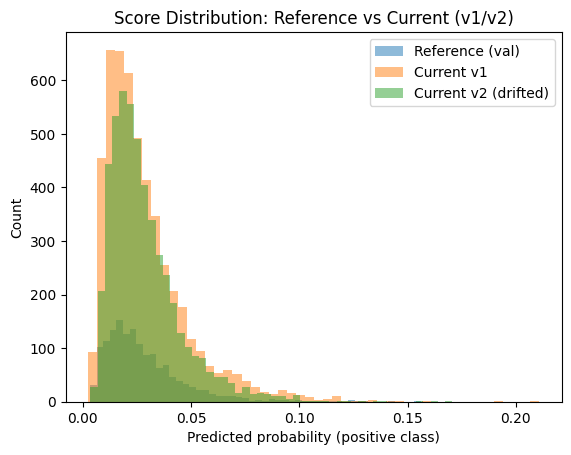

In [28]:

# Visualize score distributions
plt.figure()
plt.hist(prob_ref, bins=50, alpha=0.5, label='Reference (val)')
plt.hist(prob_cur_v1, bins=50, alpha=0.5, label='Current v1')
plt.hist(prob_cur_v2, bins=50, alpha=0.5, label='Current v2 (drifted)')
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Count")
plt.legend()
plt.title("Score Distribution: Reference vs Current (v1/v2)")
plt.show()



## 6) Calibration (Brier) & Confusion Matrix Shift

- **Brier score** ต่ำ → การคาลิเบรตดี (probability ที่พยากรณ์สอดคล้องกับความจริง)  
- **Confusion Matrix** ช่วยเห็น pattern ข้อผิดพลาด (เช่น False Positive/False Negative)

เราจะเปรียบเทียบ **Reference(v1)** กับ **Current(v1)** และ **Current(v2)**.


In [29]:

# Brier scores (สรุปไว้แล้วด้านบน แต่แสดงย้ำและ confusion matrix)
brier_ref, brier_cur_v1, brier_cur_v2


(0.026904893908819134, 0.02784371320592974, 0.02783860257609391)

In [30]:

cm_ref = confusion_matrix(yr_val, pred_ref, labels=[0,1])
cm_cur_v1 = confusion_matrix(y_cur, pred_cur_v1, labels=[0,1])
cm_cur_v2 = confusion_matrix(y_cur, pred_cur_v2, labels=[0,1])

pd.DataFrame(cm_ref, index=["True 0","True 1"], columns=["Pred 0","Pred 1"])


,Pred 0,Pred 1
True 0,1459,0
True 1,41,0


In [31]:

pd.DataFrame(cm_cur_v1, index=["True 0","True 1"], columns=["Pred 0","Pred 1"])


,Pred 0,Pred 1
True 0,4855,0
True 1,145,0


In [32]:

pd.DataFrame(cm_cur_v2, index=["True 0","True 1"], columns=["Pred 0","Pred 1"])


,Pred 0,Pred 1
True 0,4855,0
True 1,145,0



## 7) ตัดสินใจว่าเกิด **Model Drift** หรือไม่ (พร้อมเหตุผล)

กติกาเชิงปฏิบัติ (ตัวอย่างแนวทาง—ผู้สอนปรับเกณฑ์ได้):
- Metric drop:  
  - ถ้า Accuracy/F1/ROC-AUC ลดลงเกิน **3–5 จุดเปอร์เซ็นต์** จาก baseline ถือว่าน่าสงสัย  
  - LogLoss/Brier สูงขึ้นอย่างมีนัยสำคัญ → ควรตรวจสอบ
- PSI/JSD บน **predicted probability** สูงผิดปกติ → บอกใบ้ว่าสมองของโมเดล (score distribution) เปลี่ยน
- Confusion matrix: FP/FN กระจุกฝั่งใดฝั่งหนึ่งเพิ่มขึ้น

> ใช้ตารางสรุปผลในเซลล์ก่อนหน้าเพื่อพิจารณา **Current(v1)** และ **Current(v2)** เทียบกับ **Reference(v1)**.



## 8) สร้าง **Evidently Report** (Classification Performance)

- ใช้ `ClassificationPerformancePreset` เพื่อสรุป performance metrics, confusion matrix, PR/ROC, และ drift สรุป
- ใส่ข้อมูลเป็น **reference** (validation ของ v1) และ **current** (ทดสอบ v1/v2 อย่างใดอย่างหนึ่ง)

> ด้านล่างเราจะรัน **สอง** รายงาน:  
>  8.1) v1: Reference (val) vs Current (v1)  
>  8.2) v2: Reference (val) vs Current (v2, drifted)


In [33]:
from evidently import Report
from evidently.presets import ClassificationPreset   # new API

ref_evidently = pd.DataFrame({
    "y_true": yr_val.values,
    "y_pred": pred_ref,
    "y_pred_proba": prob_ref
})

cur_v1_evidently = pd.DataFrame({
    "y_true": y_cur.values,
    "y_pred": pred_cur_v1,
    "y_pred_proba": prob_cur_v1
})

cur_v2_evidently = pd.DataFrame({
    "y_true": y_cur.values,
    "y_pred": pred_cur_v2,
    "y_pred_proba": prob_cur_v2
})



In [49]:
ref_evidently

,y_true,y_pred,y_pred_proba
0,0,0,0.019609
1,0,0,0.009935
2,0,0,0.017354
3,0,0,0.025844
4,0,0,0.039525
...,...,...,...
1495,0,0,0.046974
1496,0,0,0.040140
1497,0,0,0.028889
1498,0,0,0.007388


In [46]:
cur_v1_evidently

,y_true,y_pred,y_pred_proba
0,0,0,0.009054
1,0,0,0.012003
2,0,0,0.013811
3,0,0,0.023672
4,0,0,0.014866
...,...,...,...
4995,0,0,0.021354
4996,0,0,0.025123
4997,0,0,0.028329
4998,0,0,0.042254


In [47]:
cur_v2_evidently

,y_true,y_pred,y_pred_proba
0,0,0,0.010159
1,0,0,0.014378
2,0,0,0.015601
3,0,0,0.024508
4,0,0,0.015358
...,...,...,...
4995,0,0,0.022966
4996,0,0,0.028039
4997,0,0,0.028773
4998,0,0,0.041632


In [37]:
print("Unique y_true:", np.unique(ref_evidently["y_true"]))
print("Unique y_pred:", np.unique(ref_evidently["y_pred"]))


Unique y_true: ['0' '1']
Unique y_pred: ['0']


In [39]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [ ]:
import pandas as pd
from evidently import Report, Dataset, DataDefinition, BinaryClassification
from evidently.presets import ClassificationPreset

# (Optional but recommended) ensure labels are categorical/strings
for df in (ref_evidently, cur_v1_evidently, cur_v2
    df["y_true"] = df["y_true"].astype(str)        # or category
    df["y_pred"] = df["y_pred"].astype(str)        # or category
    # y_pred_proba stays float


In [50]:
report_v1 = Report(metrics=[ClassificationPreset()])
report_v1.run(reference_data=ref_evidently, current_data=cur_v1_evidently)
report_v1


ValueError: Cannot use ClassificationPreset without a classification configration

In [ ]:

report_v2 = Report(metrics=[ClassificationPerformancePreset()])
report_v2.run(reference_data=ref_evidently, current_data=cur_v2_evidently)
report_v2



## 9) สรุปและแนวทางปฏิบัติ (Interpretation & Next Steps)

- ถ้า **Current(v1)** แทบไม่ตกจาก Reference → ยังไม่พบสัญญาณ Model Drift (หรืออาจมีเพียงเล็กน้อย).  
- ถ้า **Current(v2)** แย่ลงอย่างชัดเจน (Accuracy/F1/ROC-AUC ลด, LogLoss/Brier เพิ่ม, PSI/JSD สูงขึ้น) → **ชี้ชัดว่าเกิด Model Drift** (จากโมเดลที่เสื่อม / การตั้งค่าผิด / การแปลงไฟล์โมเดล).

**แนวทางแก้ไข (Mitigation):**
- ตรวจสอบเวอร์ชันและพารามิเตอร์ของโมเดลที่ deploy เทียบกับ baseline (config drift)
- ทำ **A/B test** ระหว่าง v1 (baseline) กับ v2 (ปัจจุบัน) เพื่อยืนยัน
- ตั้ง **monitoring & alert** บน metric สำคัญ (AUC, F1, LogLoss, Brier) และ PSI/JSD ของสกอร์
- วางรอบ **retraining** เป็นระยะ หรือใช้ **champion–challenger** และ **shadow testing**
- บันทึกด้วย **MLflow** / pipeline orchestration เพื่อง่ายต่อการ audit ภายหลัง

> การบ้าน (Optional):  
> - ลองปรับ `C` ใน v2 หรือใส่ noise ในค่าสัมประสิทธิ์ Logistic Regression แล้วสังเกตตัวชี้วัด  
> - สร้างกรณีที่ Data Drift ต่ำมาก แต่ Model Drift สูง (เหมือนใน lab นี้) เทียบกับกรณีที่ Data Drift สูงแต่ Model Drift ต่ำ



## Appendix: Version Info & Tips

- ตรวจสอบเวอร์ชัน Evidently:


In [ ]:

import evidently
evidently.__version__
